In [ ]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

In [ ]:
import pandas as pd

In [ ]:

df_train = pd.read_csv('/content/drive/My Drive/Diabetic Retinopathy/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Diabetic Retinopathy/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)

In [ ]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)

 
    return image

((3112,), (3112,), (550,), (550,))


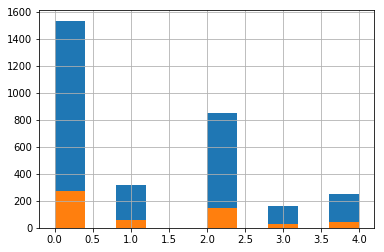

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=0)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

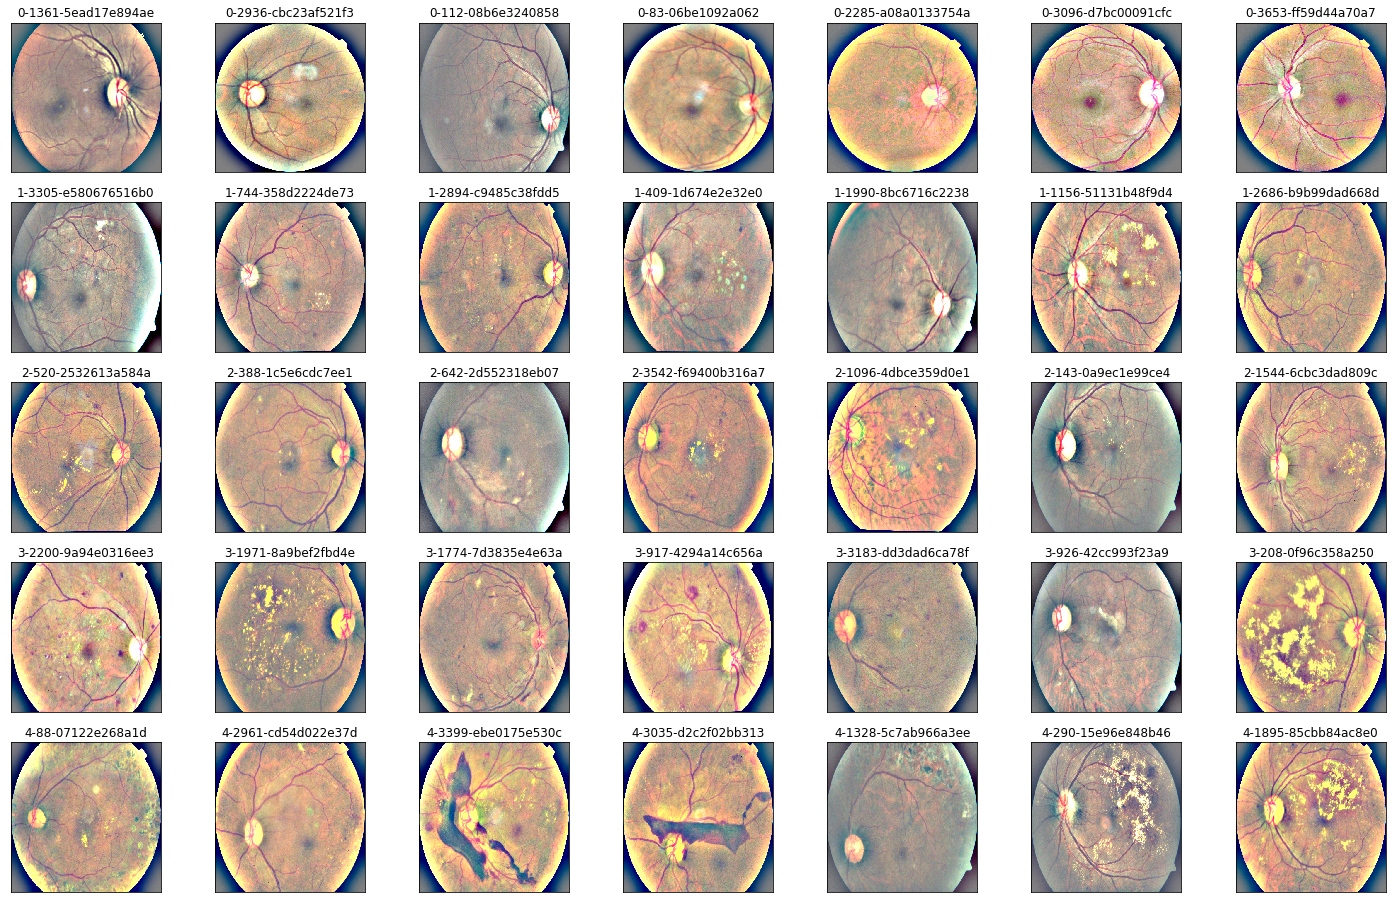

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        image = load_ben_color(path,sigmaX=30)

        plt.imshow(image)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

In [ ]:
import numpy as np

In [ ]:
def adjust_gamma(image, gamma=1.0):

   
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

In [ ]:
def extract_ma(image):
    r,g,b=cv2.split(image)
    comp=255-g
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    histe=clahe.apply(comp)
    adjustImage = adjust_gamma(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gamma(comp,gamma=4)
    J = 255-J
    J = adjust_gamma(J,gamma=4)
    
    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)
    
    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    return opening

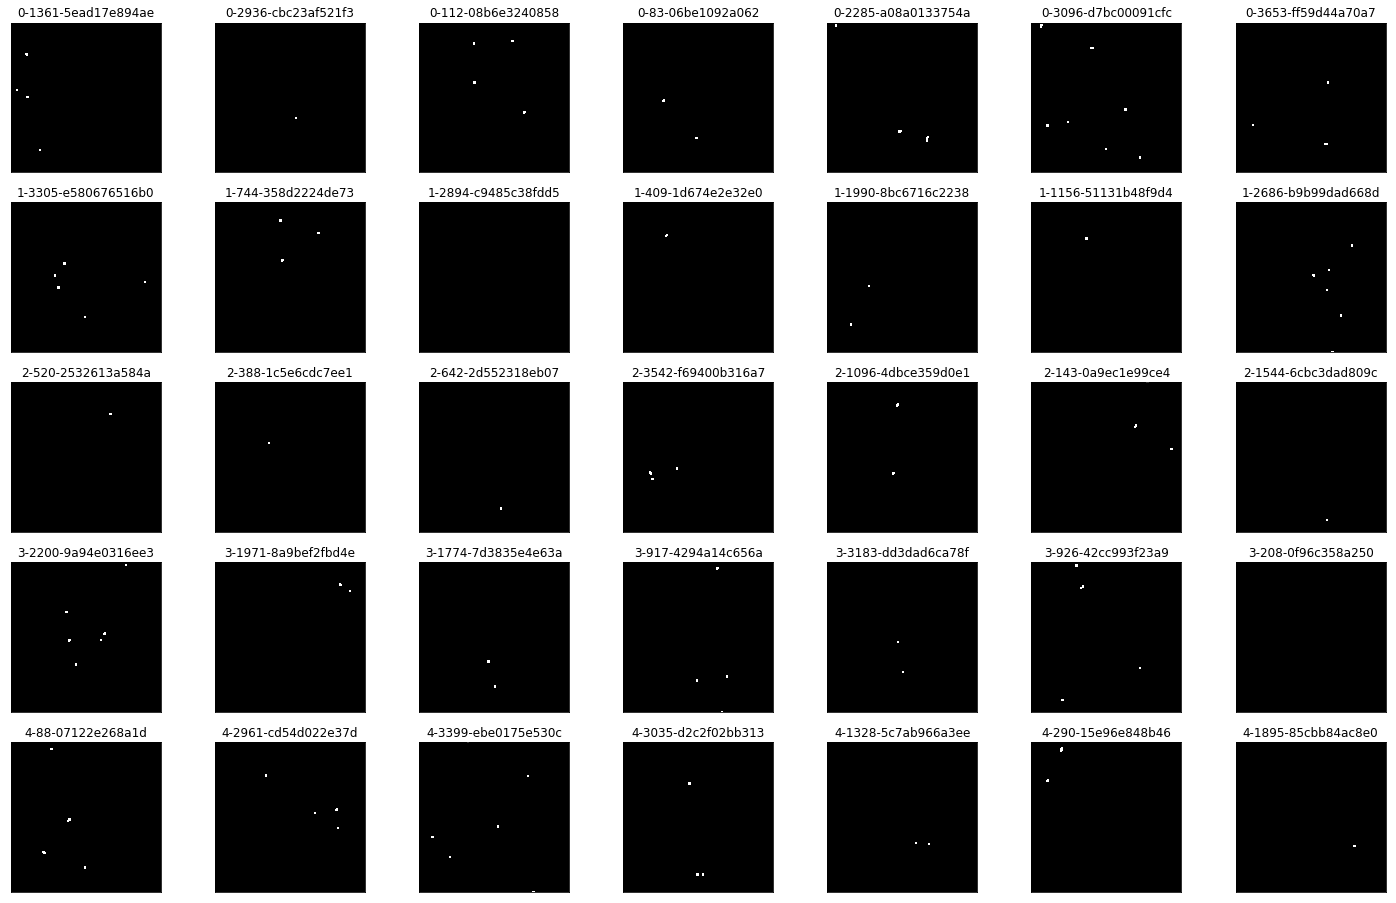

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        fundus=cv2.imread(path)
        bloodvessel = extract_ma(fundus)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

ValueError: ignored

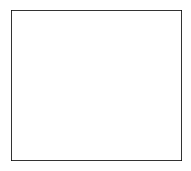

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path="/content/drive/My Drive/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        fundus=cv2.imread(path)
        bloodvessel = extract_ma(fundus)
        
#         imag = rgb2gray(bloodvessel)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

In [ ]:
def adjust_gamma(image, gamma=1.0):

   
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

In [ ]:
pip install opencv2

ERROR: Could not find a version that satisfies the requirement opencv2 (from versions: none)
ERROR: No matching distribution found for opencv2


In [ ]:
def extract_ma(image):
    r,g,b=cv2.split(image)
    comp=255-g
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    histe=clahe.apply(comp)
    adjustImage = adjust_gamma(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gamma(comp,gamma=4)
    J = 255-J
    J = adjust_gamma(J,gamma=4)
    
    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)
    
    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    return opening

In [ ]:
fundus=cv2.imread(f"/content/drive/My Drive/Diabetic Retinopath/test_images/0005cfc8afb6.png")
bloodvessel = extract_ma(fundus)
plt.imshow(bloodvessel)

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path="/content/drive/My Drive/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        fundus=cv2.imread(path)
        bloodvessel = extract_ma(fundus)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

NameError: ignored

<Figure size 1800x1152 with 0 Axes>

In [ ]:
https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html

In [ ]:
pip install SimpleCv


In [ ]:
pip install OpenCv

ERROR: Could not find a version that satisfies the requirement OpenCv (from versions: none)
ERROR: No matching distribution found for OpenCv


ImportError: ignored

In [ ]:
from SimpleCv import Image, Color
import csv

ImportError: ignored

In [ ]:
pip install pygame

     |████████████████████████████████| 11.3MB 4.5MB/s 


In [ ]:
pip install OpenCV

ERROR: Could not find a version that satisfies the requirement OpenCV (from versions: none)
ERROR: No matching distribution found for OpenCV


In [ ]:
eye=Image("/content/drive/My Drive/Diabetic Retinopath/test_images/0005cfc8afb6.png")

In [ ]:
eye=cv2.imread("/content/drive/My Drive/Diabetic Retinopath/test_images/0005cfc8afb6.png")

In [ ]:
r,g,b=cv2.split(eye)

In [ ]:
g=g*2.5

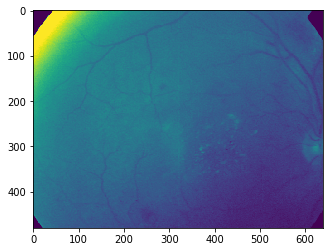

In [ ]:
plt.imshow(g)

In [ ]:
im_gray = cv2.imread("/content/drive/My Drive/Diabetic Retinopath/test_images/0005cfc8afb6.png", cv2.IMREAD_GRAYSCALE)

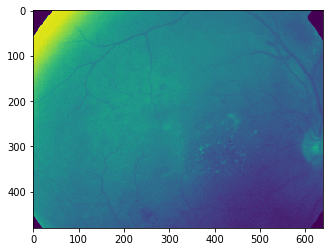

In [ ]:
plt.imshow(im_gray)

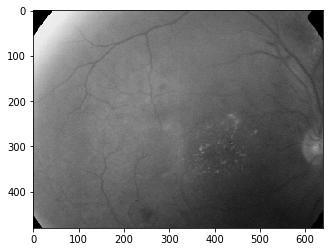

In [ ]:
plt.imshow(im_gray,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
imd=rgb2gray(eye)

In [ ]:
imgg=rgb2gray(im_gray)

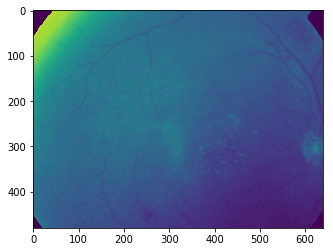

In [ ]:
plt.imshow(imd)

In [ ]:
gray = cv2.cvtColor(eye, cv2.COLOR_RGB2GRAY)

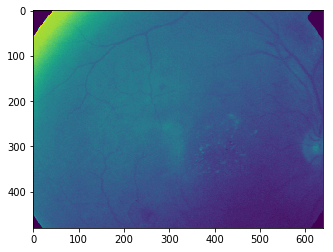

In [ ]:
plt.imshow(gray)

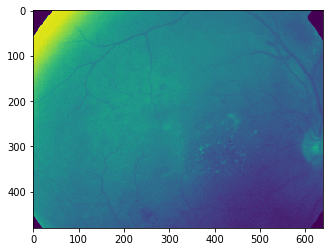

In [ ]:
img_grey = cv2.imread("/content/drive/My Drive/Diabetic Retinopath/test_images/0005cfc8afb6.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img_grey)

In [ ]:
thresh = 128

# assign blue channel to zeros
img_binary = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)[1]

#save image
cv2.imwrite("/content/drive/My Drive/Diabetic Retinopath/test_images/change.png",img_binary)

True

In [ ]:
img_grey = cv2.imread("/content/drive/My Drive/Diabetic Retinopath/test_images/0005cfc8afb6.png", cv2.IMREAD_GRAYSCALE)

In [ ]:
thresh = 128

# assign blue channel to zeros
img_binary = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)[1]

#save image
cv2.imwrite("/content/drive/My Drive/Diabetic Retinopath/test_images/change.png",img_grey)

True

In [ ]:
gray=cv2.imread("/content/drive/My Drive/Diabetic Retinopath/test_images/blur.png")

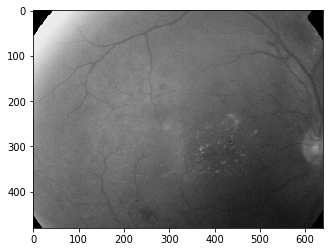

In [ ]:
plt.imshow(gray)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6341dd8c10>,
 <matplotlib.image.AxesImage at 0x7f6341cefe10>)

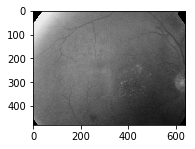

In [ ]:
edges = cv2.Canny(gray,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')

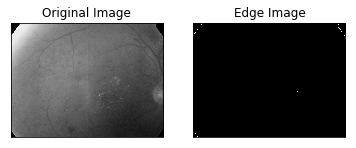

In [ ]:
edges = cv2.Canny(gray,100,200)

plt.subplot(121),plt.imshow(gray,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

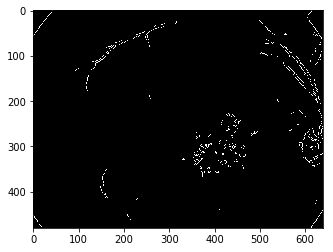

In [ ]:
edges = cv2.Canny(gray,70,35)

plt.imshow(edges,cmap = 'gray')


plt.show()

In [ ]:
cv2.imwrite("/content/drive/My Drive/Diabetic Retinopath/test_images/edge.png",edges)

True

In [ ]:
edgeimg=cv2.imread("/content/drive/My Drive/Diabetic Retinopath/test_images/edge.png")

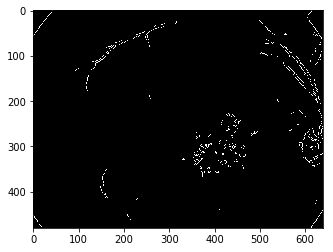

In [ ]:

plt.imshow(edgeimg)

In [ ]:
INPUT = cv2.imread("/content/drive/My Drive/Diabetic Retinopath/test_images/change.png",0)
MASK = np.array(INPUT/255.0, dtype='float32')

MASK = cv2.GaussianBlur(MASK, (5,5), 11)
BG = np.ones([INPUT.shape[0], INPUT.shape[1], 1], dtype='uint8')*255

OUT_F = np.ones([INPUT.shape[0], INPUT.shape[1], 1],dtype='uint8')

for r in range(INPUT.shape[0]):
    for c in range(INPUT.shape[1]):
        OUT_F[r][c]  = int(BG[r][c]*(MASK[r][c]) + INPUT[r][c]*(1-MASK[r][c]))

cv2.imwrite('/content/drive/My Drive/Diabetic Retinopath/test_images/blur.png', OUT_F)  

True

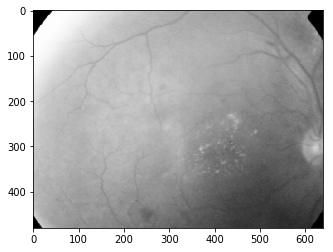

In [ ]:

plt.imshow(blurimg)

In [ ]:
eye_final=vlu

In [ ]:
blurimg=cv2.imread("/content/drive/My Drive/Diabetic Retinopath/test_images/blur.png")

In [ ]:
eye_final=edgeimg

In [ ]:

# Taking a matrix of size 5 as the kernel 
kernel = np.ones((5,5), np.uint8) 
  
eye_final = cv2.dilate(eye_final, kernel, iterations=2) 
eye_final = cv2.erode(eye_final, kernel, iterations=1) 
eye_final = cv2.dilate(eye_final, kernel, iterations=4)
eye_final = cv2.erode(eye_final, kernel, iterations=3)

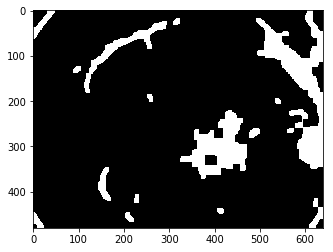

In [ ]:
plt.imshow(eye_final)

In [ ]:
cv2.imwrite("/content/drive/My Drive/Diabetic Retinopath/test_images/eyefinals.png",eye_final)

True

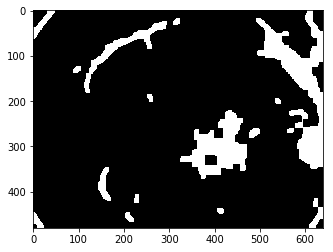

In [ ]:
eyefinals=cv2.imread("/content/drive/My Drive/Diabetic Retinopath/test_images/eyefinals.png")
plt.imshow(eyefinals)

In [ ]:
eyes=cv2.imread("/content/drive/My Drive/Diabetic Retinopath/test_images/eyefinals.jpg")	

In [ ]:
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.maxArea = 100  
    # Detect blobs.
is_v2 = cv2.__version__.startswith("2.")
if is_v2:
    detector = cv2.SimpleBlobDetector(params)
else:
    detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(eyefinals)
print keypoints

[]


In [ ]:
params = cv2.SimpleBlobDetector_Params()
params.filterByArea = True
params.minArea =   
    # Detect blobs.
is_v2 = cv2.__version__.startswith("2.")
if is_v2:
    detector = cv2.SimpleBlobDetector(params)
else:
    detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(eyefinals)
print keypoints


[<KeyPoint 0x7f16808a67e0>]


1


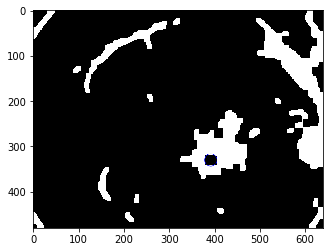

In [ ]:
blank = np.zeros((1, 1))  
blobs = cv2.drawKeypoints(eyefinals, keypoints, blank, (0, 0, 255), 
                          cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
  
number_of_blobs = len(keypoints) 
print(number_of_blobs)
text = "Number of Circular Blobs: " + str(len(keypoints)) 
cv2.putText(blobs, text, (20, 550), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 255), 2)
plt.imshow(blobs)

In [ ]:
mask = np.zeros(eyefinals.shape[:2], np.uint8)

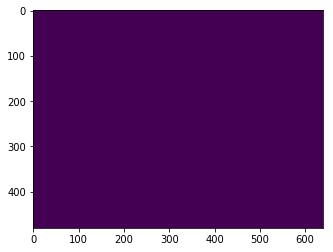

In [ ]:
plt.imshow(mask)

In [ ]:
for b in keypoints:

         #set mask
       b.image = mask

         #draw the blob on your mask
       b.draw(color = Color.WHITE)

In [ ]:
pip install opencv-python

In [ ]:


def findMA(path):
    eye = Image(path)

    (empty, eye_green, emptier) = eye.splitChannels(False)

    eye_green = eye_green * 2.5
    eye_gray = eye_green.grayscale()

    eye_gray = eye_gray.smooth()


    #Canny edge detection algorithm. t1 specifies the threshold value to begin an edge. t2 specifies the strength required
    #build an edge off of a point found by T2.
    eye_edges = eye_gray.edges(t1 = 70, t2=35)


    edge_test = eye_gray + eye_edges


    eye_final = eye_edges

    #Perform closing to find individual objects
    eye_final = eye_final.dilate(2)
    eye_final = eye_final.erode()

    eye_final = eye_final.dilate(4)
    eye_final = eye_final.erode(3)

    big_blobs = eye_final.findBlobs(minsize=500)

     #create a blank image to mask
    masked_image = Image(eye.size())

    for b in big_blobs:

         #set mask
       b.image = masked_image

         #draw the blob on your mask
       b.draw(color = Color.WHITE)



    eye_final = eye_final - masked_image.applyLayers()
    eye_final = eye_final.erode()
    eye_final = eye_final.grayscale()
    print(eye_final[100,200][0])
    print(eye_final[200,300])
    print(eye_final[400,600])
    #eye_final.save("testthis.png")


    if eye_final.findBlobs(maxsize=10):

        small_blobs = eye_final.findBlobs(maxsize=10)

        #create a blank image to mask
        masked_small_image = Image(eye.size())
        for b in small_blobs:

            #set mask
           b.image = masked_small_image

           #draw the blob on your mask
           b.draw(color = Color.WHITE)


        eye_final = eye_final - masked_small_image.applyLayers()
        # print("secondtime")
        print(eye_final[100,200])
        print(eye_final[200,300])
        print(eye_final[400,600])


    if eye_final.findBlobs():
        final_blobs = eye_final.findBlobs()

        #Filter through objects to find only potential microaneurysms
        masked_circle_image = Image(eye.size())
        for b in final_blobs:
            blob_height = b.height()
            blob_width = b.width()
            width_height_diff = abs(blob_height-blob_width)
            if (width_height_diff > .2 * blob_height) | (width_height_diff > .2 *blob_width):
                    b.image = masked_circle_image
                    b.draw(color = Color.WHITE)


            if (b.area() < .45 *blob_height * blob_width):

                    b.image = masked_circle_image
                    b.draw(color = Color.WHITE)

            #remove large pointless blobs
            if (b.area() > 1500):
                    b.image = masked_circle_image
                    b.draw(color=Color.WHITE)


        #Save different objects
        #eye_final.save("Output1.png")
        #masked_circle_image.applyLayers().save("Output2.png")

        eye_final = eye_final - masked_circle_image.applyLayers()
    eye_example = eye_final + eye

    # print("third time")
    print(eye_final[100,200])
    print(eye_final[200,300])
    print(eye_final[400,600])

    eye_example.save(file_name_without_extension+'_MAoverlay.tif')
    print("overlay saved")
    eye_final.save(file_name_without_extension+'_MA.tif')
    print("MA saved")
    # print("fourth time")
    print(eye_final[140,140])
    print(eye_final[180,180])
    print(eye_final[350,350])
    # print('lag gye')
    return eye_final

In [ ]:
image=findMA("/content/drive/My Drive/Diabetic Retinopath/test_images/0005cfc8afb6.png")

AttributeError: ignored

In [ ]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/content/drive/My Drive/Diabetic Retinopathy/train_images/{row['id_code']}.png"
        fundus=cv2.imread(path)
        bloodvessel = findMA(fundus,hello)
#         imag = rgb2gray(bloodvessel)
        plt.imshow(bloodvessel,cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']))

In [ ]:
def extract_bv(image):
  b,green_fundus,r = cv2.split(image)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  contrast_enhanced_green_fundus = clahe.apply(green_fundus)
  # applying alternate sequential filtering (3 times closing opening)
  r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
  r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
  R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
  r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
  R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
  f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
  f5 = clahe.apply(f4)

  # removing very small contours through area parameter noise removal
  ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)
  mask = np.ones(f5.shape[:2], dtype="uint8") * 255
  im2, contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  for cnt in contours:
    if cv2.contourArea(cnt) <= 200:
      cv2.drawContours(mask, [cnt], -1, 0, -1)			
  im = cv2.bitwise_and(f5, f5, mask=mask)
  ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)			
  newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

  # removing blobs of microaneurysm & unwanted bigger chunks taking in consideration they are not straight lines like blood
  # vessels and also in an interval of area
  fundus_eroded = cv2.bitwise_not(newfin)
  xmask = np.ones(image.shape[:2], dtype="uint8") * 255
  x1, xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
  for cnt in xcontours:
    shape = "unidentified"
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
    if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
      shape = "circle"	
    else:
      shape = "veins"
    if(shape=="circle"):
      cv2.drawContours(xmask, [cnt], -1, 0, -1)	
	
  finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
  blood_vessels = cv2.bitwise_not(finimage)
  dilated = cv2.erode(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations=1)
  #dilated1 = cv2.dilate(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
  blood_vessels_1 = cv2.bitwise_not(dilated)
  return blood_vessels_1

In [ ]:
import cv2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

path=f"/content/drive/My Drive/BE Project/Diabetic Retinopathy/train_images/000c1434d8d7.png"
imd = cv2.imread(path)   
print(imd)

None
